## Step 1 - Argo Data

In [1]:
# load libraries
import numpy as np
import pyxpcm
from argopy import DataFetcher as ArgoDataFetcher

import cartopy.crs as ccrs 
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

import gsw 

In [4]:
def get_argo_region_data(llon,rlon,llat,ulat,depthmin,depthmax,time_in,time_f):
        # Function to get argo data for a given lat,lon box (using Argopy), 
    # and return a 2D array collection of vertical profile for the given region
    #llon: left longitude
    #rlon: right longtidue
    #ulat: upper latitude
    #llat: lower latitude
    ds_points = ArgoDataFetcher(src='erddap').region([llon,rlon, llat,ulat, depthmin, depthmax,time_in,time_f]).to_xarray()
    ds_profiles = ds_points.argo.point2profile()
    return ds_profiles

In [5]:
llon=-90;rlon=0
ulat=70;llat=0 
depthmin=0;depthmax=1000
# January 
time_in='2011-01'
time_f='2011-02'

## (i) Get data

In [6]:
ds = get_argo_region_data(llon,rlon,llat,ulat,depthmin,depthmax,time_in,time_f)
ds

<xarray.Dataset>
Dimensions:          (N_LEVELS: 500, N_PROF: 1289)
Coordinates:
    LONGITUDE        (N_PROF) float64 -35.95 -1.999 -2.629 ... -13.97 -16.71
  * N_PROF           (N_PROF) int64 786 130 126 757 122 ... 951 1053 279 1093
    LATITUDE         (N_PROF) float64 20.4 0.2 1.544 58.81 ... 10.02 59.53 63.01
  * N_LEVELS         (N_LEVELS) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
    TIME             (N_PROF) datetime64[ns] 2011-01-01T03:24:35 ... 2011-01-...
Data variables:
    CYCLE_NUMBER     (N_PROF) int64 19 94 94 19 94 166 ... 172 89 124 80 188 26
    DATA_MODE        (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'A' 'D'
    DIRECTION        (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_PROF) int64 5903276 1901096 1901095 ... 4900676 6900615
    POSITION_QC      (N_PROF) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PRES             (N_PROF, N_LEVELS) float32 6.1 10.4 19.8 ... nan nan nan
    PRES_QC          (N_PROF) int64 1 1 1 1 1 1 1 1 1 1 ... 2 1 1 2 1 1 1 1 1 2
    PSAL             (N_PROF, N_LEVELS) float32 36.98597 37.00794 ... nan nan
    PSAL_QC          (N_PROF, N_LEVELS) int64 1 1 1 1 ... 99999 99999 99999
    TEMP             (N_PROF, N_LEVELS) float32 25.613 25.637 25.641 ... nan nan
    TEMP_QC          (N_PROF, N_LEVELS) int64 1 1 1 1 ... 99999 99999 99999
    TIME_QC          (N_PROF) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           jovyan
    Fetched_date:         2020/08/13
    Fetched_constraints:  phy_[x=-90.00/0.00; y=0.00/70.00; z=0.0/1000.0; t=2...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

## Plot

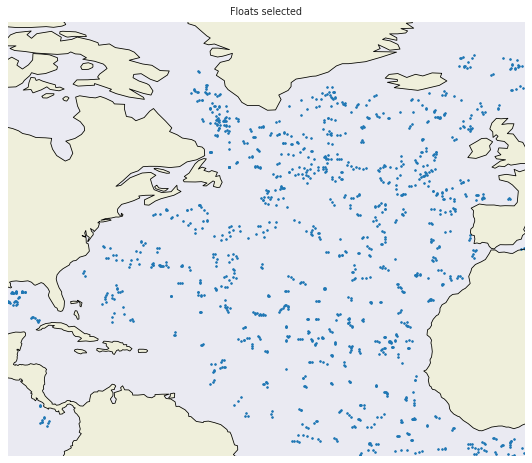

In [7]:
plt.figure(figsize=(15,8))
    
ax = plt.subplot(111, projection=ccrs.PlateCarree()
                 #Mercator()
                 )
ax.set_extent([llon,rlon,llat,ulat])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
sc = ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], s=3)

plt.title('Floats selected')
plt.show()

## (ii) Check QC

According to Argo manual: 
- QC flag values of 1, 2, 5, or 8 are GOOD data
- QC flag values of 9 (missing) are NOT USED in the computation
- All other QC flag values are BAD data 

Page 57 in http://www.odip.org/documents/odip/downloads/20/argo-dm-user-manual.pdf

In [8]:
goodflags=[1,2,5,8]
badflags=[3,4,6,7,9]
QC=['POSITION_QC','PRES_QC','TEMP_QC','PSAL_QC','TIME_QC']
for q in QC:
    data=np.array(ds[q])
    for f in badflags:
        if np.any(data)==f: 
            print('Bad data in '+str(q)+' QC flag: '+str(f))

## (iii) Delayed X Real time Data

DATA_MODE(PROF_N):

R : real time data

D : delayed mode data

A : real time data with adjusted values

In [9]:
ds.DATA_MODE

<xarray.DataArray 'DATA_MODE' (N_PROF: 1289)>
array(['D', 'D', 'D', ..., 'D', 'A', 'D'], dtype='<U1')
Coordinates:
    LONGITUDE  (N_PROF) float64 -35.95 -1.999 -2.629 ... -20.71 -13.97 -16.71
  * N_PROF     (N_PROF) int64 786 130 126 757 122 889 ... 1005 951 1053 279 1093
    LATITUDE   (N_PROF) float64 20.4 0.2 1.544 58.81 ... 30.94 10.02 59.53 63.01
    TIME       (N_PROF) datetime64[ns] 2011-01-01T03:24:35 ... 2011-01-31T23:...
Attributes:
    casted:   1

In [10]:
ds2=ds.where(ds.DATA_MODE=='D',drop=True)
print('We selected '+str(len(ds2.N_PROF))+' from '+str(len(ds.N_PROF)))


We selected 1143 from 1289


In [18]:
ds2

<xarray.Dataset>
Dimensions:          (N_LEVELS: 500, N_PROF: 1143)
Coordinates:
    LONGITUDE        (N_PROF) float64 -35.95 -1.999 -2.629 ... -20.71 -16.71
  * N_PROF           (N_PROF) int64 786 130 126 757 122 ... 1005 951 1053 1093
    LATITUDE         (N_PROF) float64 20.4 0.2 1.544 58.81 ... 30.94 10.02 63.01
  * N_LEVELS         (N_LEVELS) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
    TIME             (N_PROF) datetime64[ns] 2011-01-01T03:24:35 ... 2011-01-...
Data variables:
    CYCLE_NUMBER     (N_PROF) float64 19.0 94.0 94.0 19.0 ... 124.0 80.0 26.0
    DATA_MODE        (N_PROF) object 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D' 'D'
    DIRECTION        (N_PROF) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_PROF) float64 5.903e+06 1.901e+06 ... 6.901e+06
    POSITION_QC      (N_PROF) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    PRES             (N_PROF, N_LEVELS) float32 6.1 10.4 19.8 ... nan nan nan
    PRES_QC          (N_PROF) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 2.0
    PSAL             (N_PROF, N_LEVELS) float32 36.98597 37.00794 ... nan nan
    PSAL_QC          (N_PROF, N_LEVELS) float64 1.0 1.0 1.0 ... 1e+05 1e+05
    TEMP             (N_PROF, N_LEVELS) float32 25.613 25.637 25.641 ... nan nan
    TEMP_QC          (N_PROF, N_LEVELS) float64 1.0 1.0 1.0 ... 1e+05 1e+05
    TIME_QC          (N_PROF) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           jovyan
    Fetched_date:         2020/08/13
    Fetched_constraints:  phy_[x=-90.00/0.00; y=0.00/70.00; z=0.0/1000.0; t=2...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

## (iii) Vertical Interpolation

' We finally interpolated the data on a regular vertical grid with a 5 m resolution (the original resolution ranges from less than 10 m at the surface to 200 m at the bottom of the profile)' - maze et al. 2017

In [55]:
z=np.arange(10.,1000,5.)
ds_interp = ds2.argo.interp_std_levels(z)
print(ds_interp)

<xarray.Dataset>
Dimensions:            (N_PROF: 750, PRES_INTERPOLATED: 198)
Coordinates:
    LONGITUDE          (N_PROF) float64 -16.39 -24.69 -40.72 ... -11.92 -16.71
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) float64 10.0 15.0 ... 990.0 995.0
  * N_PROF             (N_PROF) int64 976 1000 1078 633 ... 911 1005 951 1093
    LATITUDE           (N_PROF) float64 27.29 50.21 55.6 ... 60.5 30.94 63.01
    TIME               (N_PROF) datetime64[ns] 2011-01-01T04:48:22 ... 2011-0...
Data variables:
    CYCLE_NUMBER       (N_PROF) float64 157.0 87.0 124.0 2.0 ... 89.0 124.0 26.0
    DATA_MODE          (N_PROF) object 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    DIRECTION          (N_PROF) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER    (N_PROF) float64 6.901e+06 6.901e+06 ... 6.901e+06
    PRES               (N_PROF, PRES_INTERPOLATED) float32 10.0 15.0 ... 995.0
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 36.98923 ... 35.05...
    TEMP               (N_P

So, when we interpolate, the number of profiles decreases a lot, because only the profiles that have data in the interval we asked is kept!

In [59]:
print('The number of profiles changed from  '+str(len(ds2.N_PROF))+ ' to '+str(len(ds_interp.N_PROF)))


The number of profiles changed from  1143 to 750


## (v) Pressure to Depth

In [60]:
ds3=ds_interp

In [66]:
p=np.array(ds3.PRES)
lat=np.array(ds3.LATITUDE)
z=np.ones_like(p)
prof=np.array(ds3.N_PROF)


In [67]:
p.shape

(750, 198)

In [65]:
lat.shape

(750,)

In [68]:
gsw.z_from_p(p[:,0], lat[:])


array([ -9.93380293,  -9.91385723,  -9.90911419,  -9.94111283,
        -9.93494363,  -9.91635559,  -9.92521023,  -9.93011033,
        -9.93176421,  -9.90770047,  -9.93678707,  -9.90790144,
        -9.90571081,  -9.93103676,  -9.90469937,  -9.90343701,
        -9.93569458,  -9.90815687,  -9.92093725,  -9.93543395,
        -9.93410594,  -9.93779956,  -9.92558346,  -9.93763266,
        -9.93429887,  -9.93224133,  -9.93627016,  -9.93281796,
        -9.92682603, -19.96610254,  -9.92774365,  -9.94081049,
        -9.92228502,  -9.90474984,  -9.91231833,  -9.93908657,
        -9.9241906 ,  -9.94087657,  -9.91007852,  -9.90248471,
        -9.91558873,  -9.91896189,  -9.93885099,  -9.91855084,
        -9.92473057,  -9.94256432,  -9.9115077 ,  -9.93978334,
       -24.8398148 ,  -9.9101452 ,  -9.9284462 ,  -9.91561328,
        -9.94106848,  -9.9065918 ,  -9.93332294,  -9.93872754,
       -29.7971342 ,  -9.92937329,  -9.91725239,  -9.93355709,
        -9.92060514,  -9.90870939,  -9.90002498,  -9.90

So we can just use the pressure as the depth axis.. I dont think we need to actually convert it.. 

## Dimensionality Reduction